#### EDA Pipeline

In [1]:
## IMPORTING NECESSARY PACKAGES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.impute import SimpleImputer
## Suppress all warnings
warnings.filterwarnings('ignore')

## Set visualization style
sns.set(style="whitegrid")

#### 1. Data Loading

In [2]:
## Load listings data  (NYC)
nyc_train = pd.read_csv('Dataset/nyc_train.csv')  
  
## Load reviews data  (london)
london_train = pd.read_csv('Dataset/london_train.csv')  

In [3]:
## Concat the cities
train_set = pd.concat([nyc_train, london_train], axis=0)

#### 2. Data Overview

In [4]:
## DATA VIEW 
print('NUMBER OF RECORDS: ', train_set.shape[0])
print('NUMBER OF FEATURES:', train_set.shape[1])
print('FEATURE LIST:', train_set.columns.to_list())

NUMBER OF RECORDS:  437364
NUMBER OF FEATURES: 30
FEATURE LIST: ['listing_id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'neighborhood_overview', 'host_id', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'reviews_per_month', 'city', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments', 'subjectivity', 'polarity', 'polarity_class']


#### 3. Data Cleaning

In [5]:
## View Basic Information about the Dataset
print(train_set.info())

<class 'pandas.core.frame.DataFrame'>
Index: 437364 entries, 0 to 275295
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   listing_id                      437364 non-null  int64  
 1   listing_url                     437364 non-null  object 
 2   scrape_id                       437364 non-null  int64  
 3   last_scraped                    437364 non-null  object 
 4   name                            437359 non-null  object 
 5   neighborhood_overview           322070 non-null  object 
 6   host_id                         437364 non-null  int64  
 7   number_of_reviews               437364 non-null  int64  
 8   number_of_reviews_ltm           437364 non-null  int64  
 9   number_of_reviews_l30d          437364 non-null  int64  
 10  first_review                    437364 non-null  object 
 11  last_review                     437364 non-null  object 
 12  review_scores_rating 

In [6]:
## Summary statistics of categorical columns
print(train_set.describe(include=['object']))

                                  listing_url last_scraped  \
count                                  437364       437364   
unique                                  64122            6   
top     https://www.airbnb.com/rooms/37122502   2024-07-05   
freq                                      440       115474   

                                                   name  \
count                                            437359   
unique                                            62867   
top     Double Garden View room - London House Hotel***   
freq                                                614   

                                    neighborhood_overview first_review  \
count                                              322070       437364   
unique                                              34568         4496   
top     The apartment is perfectly sandwiched between ...   2015-09-21   
freq                                                 1628          652   

       last_review    

In [7]:
## Check for missing values  
print("Missing Values in the Training Set")  
listings_nan_counts = train_set.isnull().sum()
print(listings_nan_counts[listings_nan_counts > 0])  

Missing Values in the Training Set
name                                5
neighborhood_overview          115294
review_scores_accuracy             14
review_scores_cleanliness           9
review_scores_checkin              18
review_scores_communication        16
review_scores_location             17
review_scores_value                18
reviewer_name                       2
dtype: int64


In [8]:
## Ways of addressing the nan values
# 1. 'name': Fill missing values with the most frequent value (mode)
train_set['name'].fillna(train_set['name'].mode()[0], inplace=True)

# 2. 'neighborhood_overview': Dropping this column due to a large number of missing values 
train_set.drop(columns=['neighborhood_overview'], axis=1, inplace=True)

# For review score columns, we can use the mean or median for imputation
review_score_columns = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                        'review_scores_communication', 'review_scores_location', 'review_scores_value']

## Imputer instance for imputing the numerical values using the mean value
mean_imputer = SimpleImputer(strategy='mean')

# Apply mean imputation to the review score columns
train_set[review_score_columns] = mean_imputer.fit_transform(train_set[review_score_columns])

# 3. 'reviewer_name': Fill missing values with the most frequent value (mode)
train_set['reviewer_name'].fillna(train_set['reviewer_name'].mode()[0], inplace=True)

In [9]:
## Rechecking for missing values  
print("Missing Values after imputation:")  
listings_nan_counts = train_set.isnull().sum()
print(listings_nan_counts[listings_nan_counts > 0])  

Missing Values after imputation:
Series([], dtype: int64)


#### 4. Data Visualization
#### Q.1: How do the distributions of various review scores compare between New York City (NYC) and London for Airbnb listings?

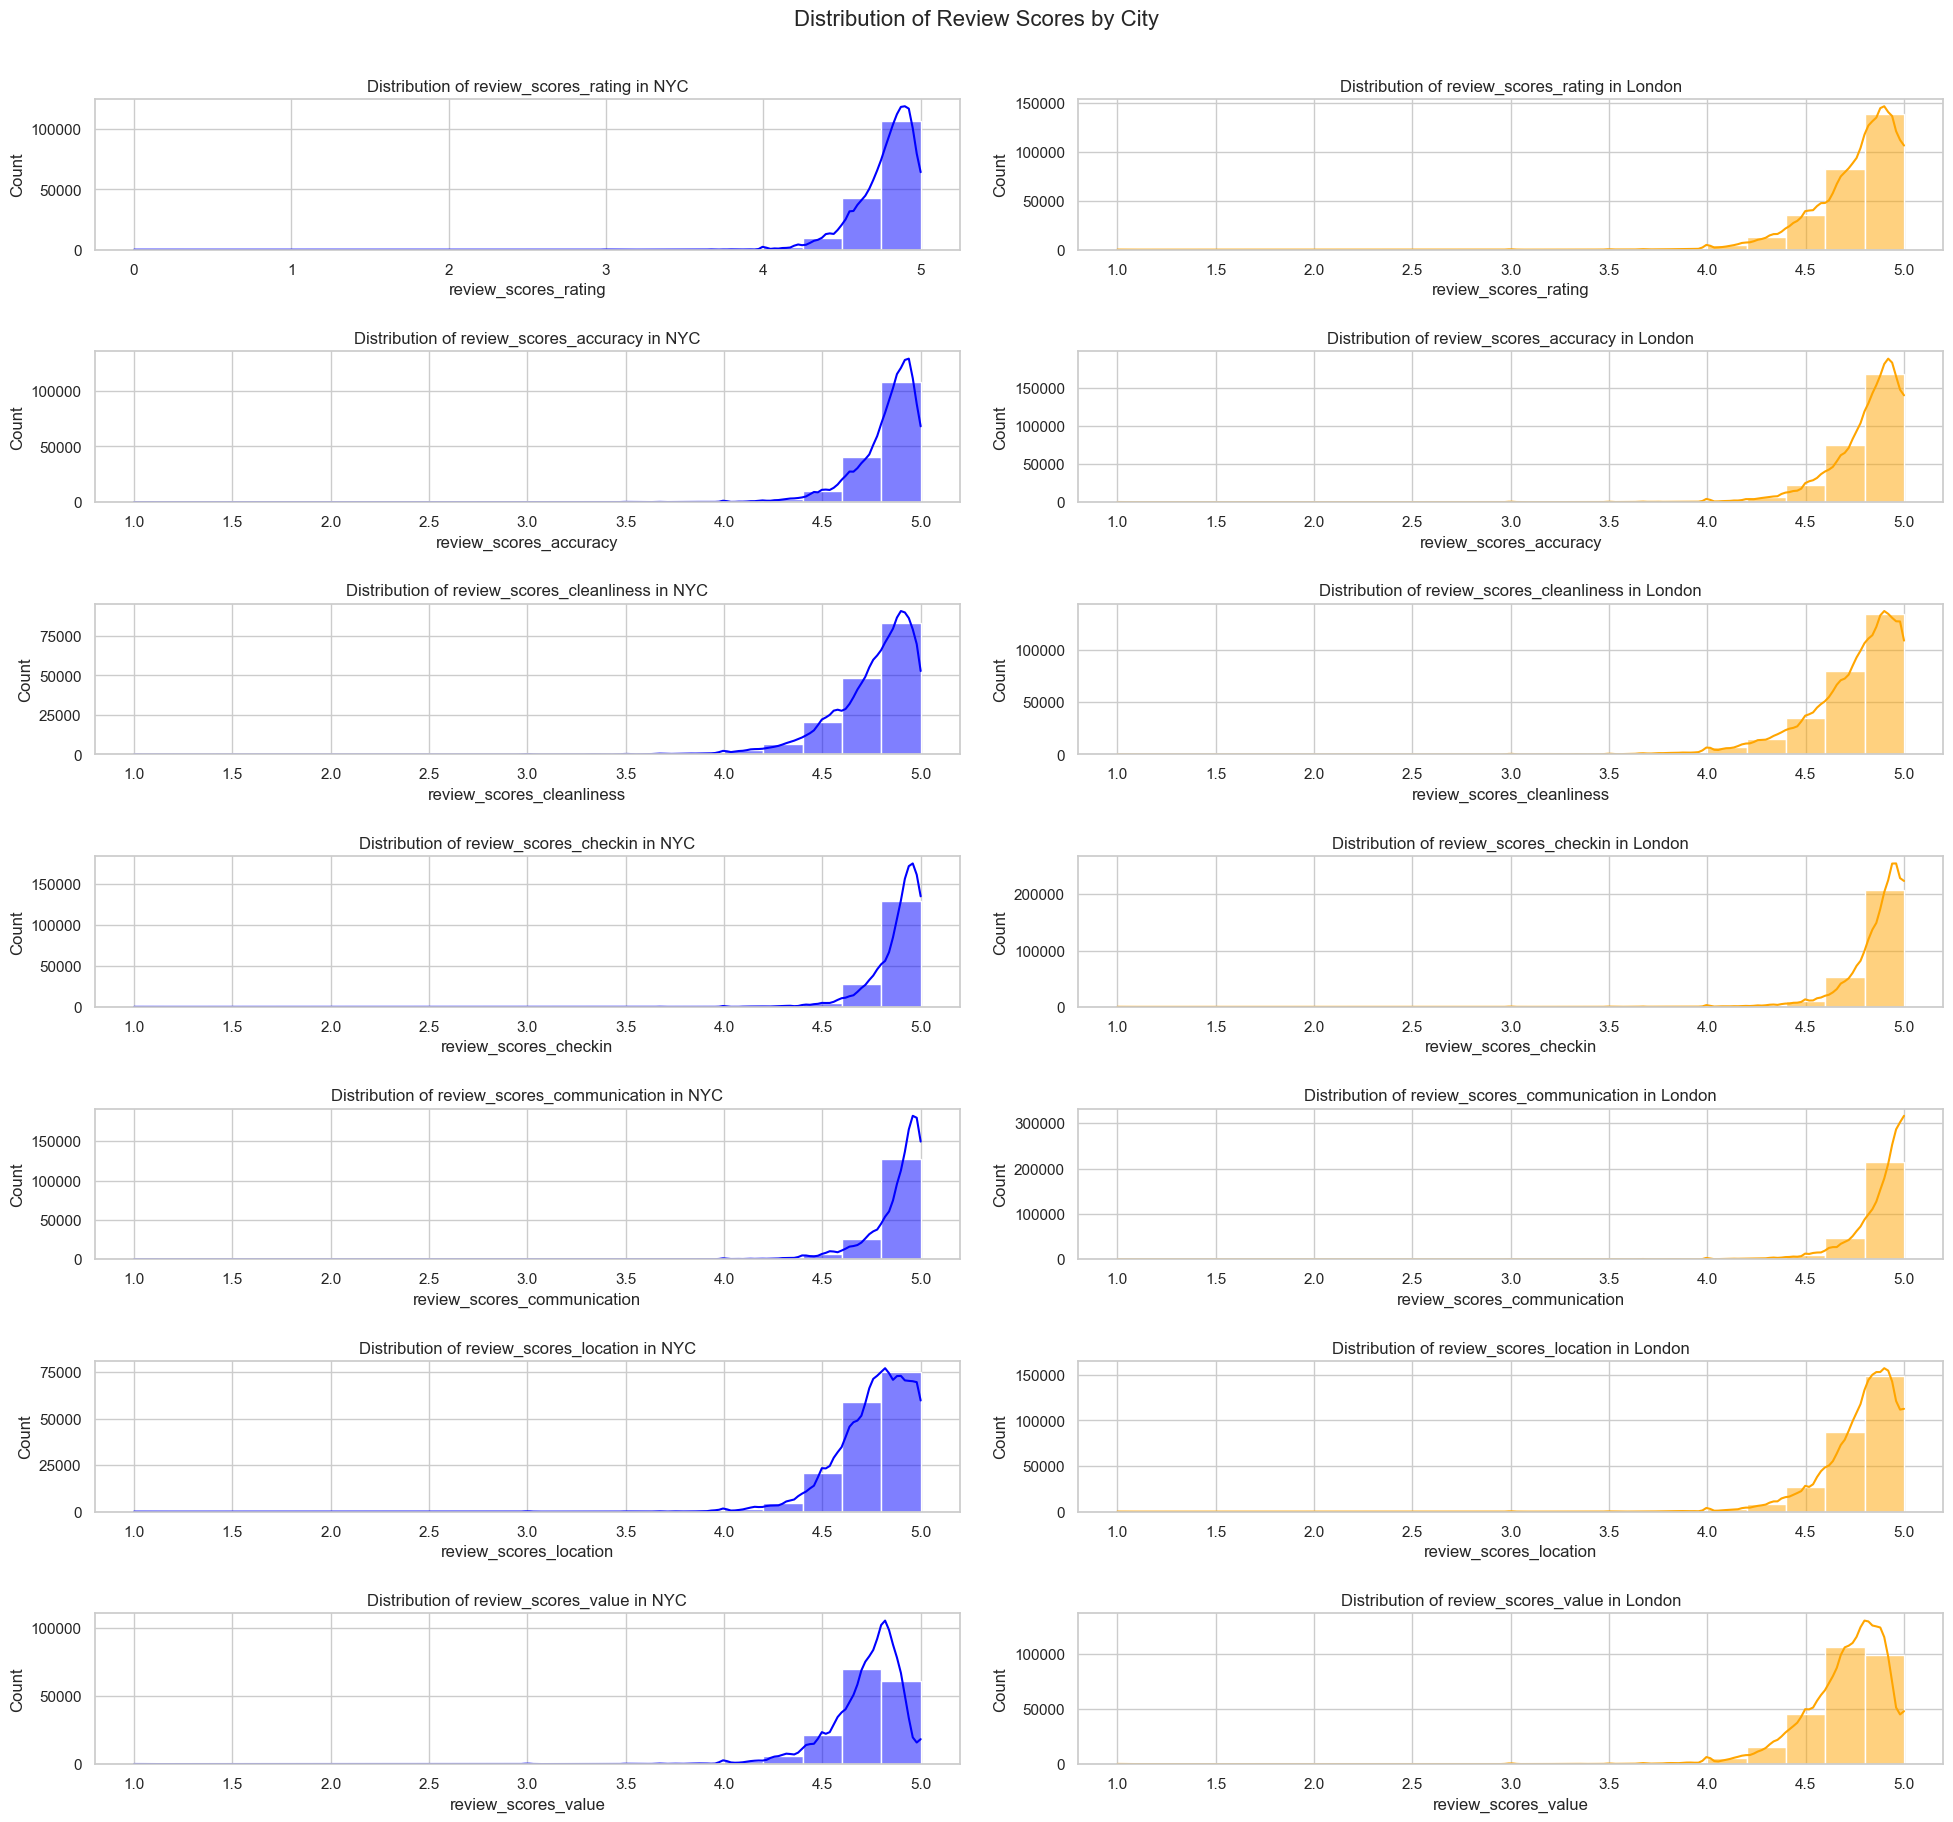

In [10]:
## Distribution of review scores
review_columns = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
                  'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
                  'review_scores_value']

## Create a figure for plotting
plt.figure(figsize=(20, 18))

## Iterate over each review type to create subplots
for i, column in enumerate(review_columns, 1):
    plt.subplot(len(review_columns), 2, i*2-1)
    sns.histplot(train_set[train_set['city']=='nyc'][column], bins=20, kde=True, color='blue')
    plt.title(f'Distribution of {column} in NYC')
    plt.xlabel(column)
    plt.ylabel('Count')

    plt.subplot(len(review_columns), 2, i*2)
    sns.histplot(train_set[train_set['city']=='london'][column], bins=20, kde=True, color='orange')
    plt.title(f'Distribution of {column} in London')
    plt.xlabel(column)
    plt.ylabel('Count')

## Show plot
plt.tight_layout(pad=2.0)
plt.suptitle('Distribution of Review Scores by City', y=1.02, fontsize=16)
plt.show()

***Insights:***
- London reviewers tend to give higher ratings across all categories compared to NYC reviewers.
- Also, it seems the distributions of review scores in London are a little more spread out, indicating more diverse opinions compared to the more concentrated distributions in NYC.

#### Q.2: How do the trends in the number of Airbnb reviews over time compare between New York City (NYC) and London?

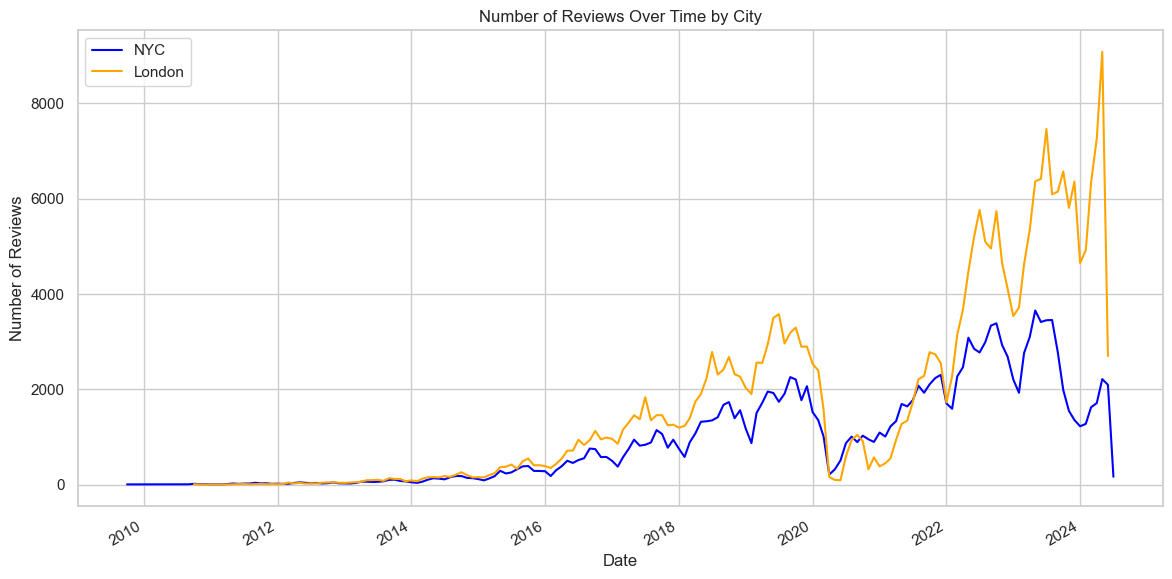

In [11]:
## Group by city and month, and count the number of reviews
train_set['date'] = pd.to_datetime(train_set['date'], errors='coerce')
reviews_over_time = train_set.groupby(['city', train_set['date'].dt.to_period('M')]).size().unstack(level=0)

## Convert PeriodIndex to Timestamp for plotting
reviews_over_time.index = reviews_over_time.index.to_timestamp()

## Plot number of reviews over time for both cities
plt.figure(figsize=(14, 7))
reviews_over_time['nyc'].plot(kind='line', label=f'NYC', color='blue')
reviews_over_time['london'].plot(kind='line', label=f'London', color='orange')
plt.title('Number of Reviews Over Time by City')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.legend()
plt.show()

#### Q.3: Who are the top ten hosts with the most Airbnb listings, and how many listings do they each have?

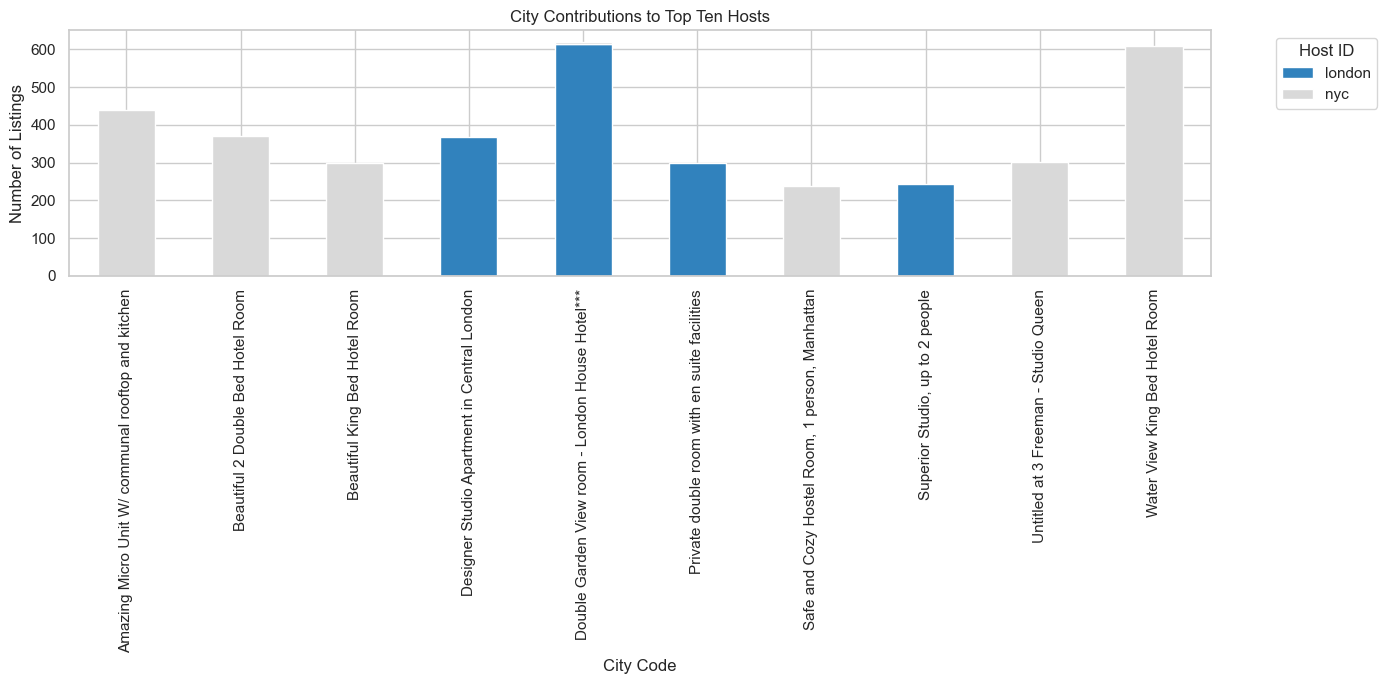

In [12]:
## Identify the top ten hosts based on the number of listings
top_hosts = train_set['name'].value_counts().nlargest(10).index

## Filter the dataset for the top ten hosts
top_hosts_listings = train_set[train_set['name'].isin(top_hosts)]

## Determine each city's contribution to the top ten hosts
city_contributions = top_hosts_listings.groupby(['name', 'city']).size().unstack(fill_value=0)

## Plotting the data
plt.figure(figsize=(14, 7))
city_contributions.plot(kind='bar', stacked=True, colormap='tab20c', ax=plt.gca())
plt.title('City Contributions to Top Ten Hosts')
plt.xlabel('City Code')
plt.ylabel('Number of Listings')
plt.xticks(rotation=90)
plt.legend(title='Host ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

***Insights:***
- Among 437,364 listings and 62,867 unique hosts, the top ten hosts each manage between approximately 250 to 600 listings.<br>
- It appears that NYC dominates the top ten listings, with 6 out of the top ten hosts located in the city.

#### Q.4: What correlations can be observed between subjectivity and polarity?

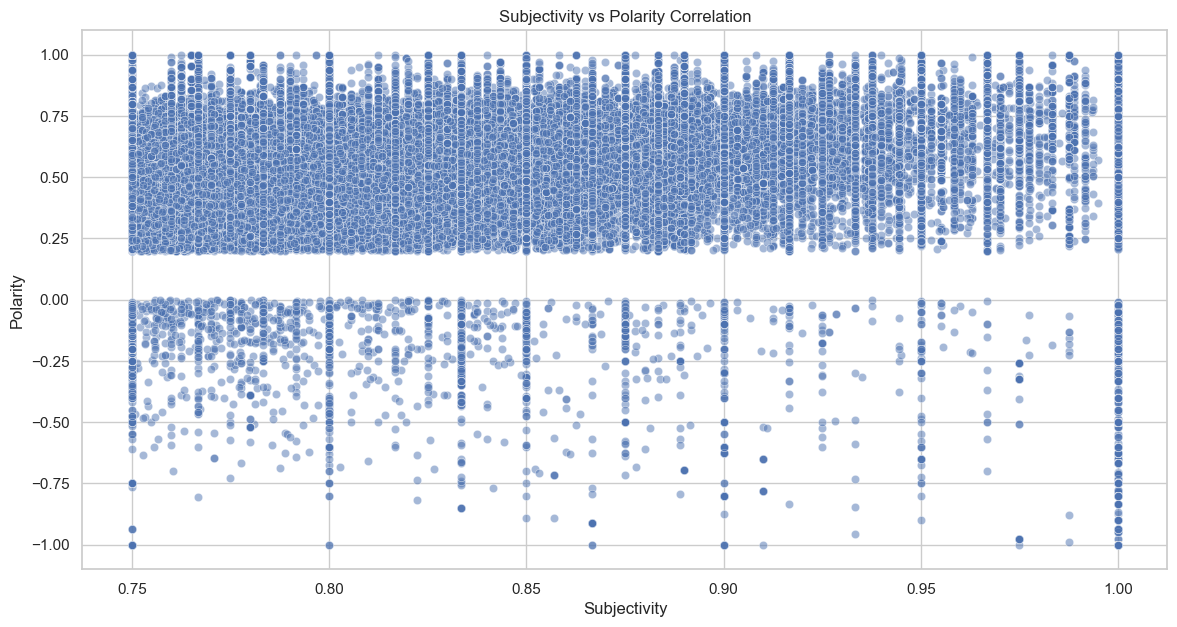

In [13]:
## Scatter plot for subjectivity Vs polarity
plt.figure(figsize=(14, 7))
sns.scatterplot(data=train_set, x='subjectivity', y='polarity', alpha=0.5)
plt.title('Subjectivity vs Polarity Correlation')
plt.xlabel('Subjectivity')
plt.ylabel('Polarity')
plt.show()

***Inisghts:***
- This illustrates a high concentration of data points where subjectivity is high (0.75-1.00) with polarity distributed between -1 and 1.
- This indicates that highly subjective texts are equally likely to convey either positive or negative sentiment. There is no clear correlation between the two sentiment measures.

#### Q.5: What is the class balance of sentiment (polarity) in Airbnb reviews?

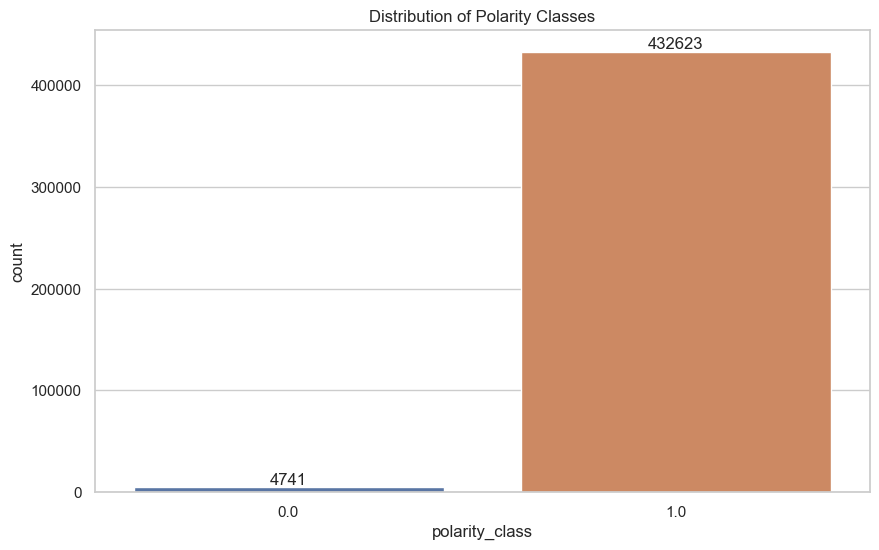

In [14]:
## Polarity class distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=train_set, x='polarity_class')
plt.title('Distribution of Polarity Classes')

## Add count labels
for container in ax.containers:
    ax.bar_label(container, labels=[f'{int(v.get_height())}' for v in container])

plt.show()

***Insights:***
- There is a significant class imbalance in the data, with the majority class having a polarity of 1.0 (~ 99% of the dataset) compared to the minority class with a polarity of 0.0 (~1% of the dataset).
- This requires resampling the dataset